In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
from plotnine import *

In [2]:
bus_raw = pd.read_parquet("/home/data/bus-weather/raw_bus_gtfs_rt_202230917_20230930.parquet").rename({"vehicle.trip.trip_id" : "trip_id", "vehicle.vehicle.id" : "bus_id", "vehicle.timestamp" : "timestamp"}, axis = 1).drop_duplicates()
bus_gdf = gpd.GeoDataFrame(bus_raw, geometry=gpd.points_from_xy(bus_raw['vehicle.position.longitude'], bus_raw['vehicle.position.latitude'])).set_crs(4326).to_crs(2263)
bus_gdf['date'] = pd.to_datetime(bus_gdf['timestamp']).dt.date
bus_gdf['hour'] = pd.to_datetime(bus_gdf['timestamp']).dt.hour
bus_gdf_trim = bus_gdf[["trip_id", "bus_id", "date", "hour",  "timestamp", "geometry"]].sort_values(["trip_id", "timestamp"])

In [3]:
def calculate_differences(group):
    group = group.sort_values(by='timestamp')
    group['distance_to_next'] = group.geometry.distance(group.geometry.shift(-1))
    group['time_to_next'] = (group['timestamp'].shift(-1) - group['timestamp']).dt.total_seconds()
    return group

In [4]:
bus_gdf_trim = bus_gdf_trim.groupby('bus_id').apply(calculate_differences).reset_index(drop=True).to_crs(4326)

/tmp/ipykernel_9385/4200393291.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [5]:
bus_gdf_trim = bus_gdf_trim.query("time_to_next < 120")
bus_gdf_trim["dist_miles"] = bus_gdf_trim["distance_to_next"] / 5280
bus_gdf_trim["speed_mph"] = (bus_gdf_trim["dist_miles"] / bus_gdf_trim["time_to_next"]) * 3600
bus_gdf_trim = bus_gdf_trim.query("speed_mph < 100")

In [6]:
ntas = gpd.read_file("https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson")
ntas = ntas[["ntaname", "boroname", "geometry"]]
bus_nta = gpd.sjoin(bus_gdf_trim, ntas, how="inner", op="within")

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [7]:
bus_nta['flood_indicator'] = bus_nta['date'].apply(lambda x: "Flooding" if x.month == 9 and x.day == 29 else "Not flooding")
bus_nta["date"] =  pd.to_datetime(bus_nta['date'])

In [8]:
bus_nta

,trip_id,bus_id,date,hour,timestamp,geometry,distance_to_next,time_to_next,dist_miles,speed_mph,index_right,ntaname,boroname,flood_indicator
0,WF_D3-Weekday-SDon-117900_SBS6_165,MTA NYCT_1000,2023-09-16,0,2023-09-16 00:00:23,POINT (-73.91746 40.82527),700.280351,61.0,0.132629,7.827277,78,Concourse-Concourse Village,Bronx,Not flooding
1,WF_D3-Weekday-SDon-117900_SBS6_165,MTA NYCT_1000,2023-09-16,0,2023-09-16 00:01:24,POINT (-73.91510 40.82457),586.852316,90.0,0.111146,4.445851,74,Morrisania,Bronx,Not flooding
2,WF_D3-Weekday-SDon-117900_SBS6_165,MTA NYCT_1000,2023-09-16,0,2023-09-16 00:02:54,POINT (-73.91313 40.82397),273.394104,31.0,0.051779,6.013067,74,Morrisania,Bronx,Not flooding
3,WF_D3-Weekday-SDon-117900_SBS6_165,MTA NYCT_1000,2023-09-16,0,2023-09-16 00:03:25,POINT (-73.91221 40.82370),757.119945,61.0,0.143394,8.462593,74,Morrisania,Bronx,Not flooding
4,WF_D3-Weekday-SDon-117900_SBS6_165,MTA NYCT_1000,2023-09-16,0,2023-09-16 00:04:26,POINT (-73.90961 40.82436),282.771153,60.0,0.053555,3.213309,74,Morrisania,Bronx,Not flooding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38045221,37568141-BPPD3-BP_D3-Saturday-04,MTABC_9007,2023-09-30,23,2023-09-30 23:54:30,POINT (-73.75648 40.71347),803.986180,60.0,0.152270,9.136207,220,Hollis,Queens,Not flooding
38045222,37568141-BPPD3-BP_D3-Saturday-04,MTABC_9007,2023-09-30,23,2023-09-30 23:55:30,POINT (-73.75365 40.71395),807.030618,60.0,0.152847,9.170802,223,Queens Village,Queens,Not flooding
38045223,37568141-BPPD3-BP_D3-Saturday-04,MTABC_9007,2023-09-30,23,2023-09-30 23:56:30,POINT (-73.75092 40.71473),40.072500,60.0,0.007589,0.455369,223,Queens Village,Queens,Not flooding
38045224,37568141-BPPD3-BP_D3-Saturday-04,MTABC_9007,2023-09-30,23,2023-09-30 23:57:30,POINT (-73.75079 40.71477),793.178473,60.0,0.150223,9.013392,223,Queens Village,Queens,Not flooding


In [9]:
fridays = bus_nta[bus_nta['date'].dt.weekday == 4]
flood_speeds = fridays.groupby(["flood_indicator", "ntaname", "boroname", "hour"]).agg({"speed_mph" : "mean", "trip_id" : "nunique"}).reset_index().pivot(index=["ntaname", "boroname", 'hour'], columns="flood_indicator", values=["trip_id", "speed_mph"])
flood_speeds = flood_speeds.reset_index()
flood_speeds.columns = ['_'.join(col).strip() for col in flood_speeds.columns.values]
flood_speeds = flood_speeds.rename({"ntaname_" : "ntaname", "hour_" : "hour", "boroname_" : "boroname", "trip_id_Flooding" : "unique_buses_flooding", "trip_id_Not flooding" : "unique_buses_not_flooding", "speed_mph_Flooding" : "speed_mph_flooding",  "speed_mph_Not flooding" : "speed_mph_not_flooding"}, axis = 1)
flood_speeds["speed_ratio"] = flood_speeds["speed_mph_flooding"] / flood_speeds["speed_mph_not_flooding"]
flood_speeds["bus_count_ratio"] = flood_speeds["unique_buses_flooding"] / flood_speeds["unique_buses_not_flooding"]

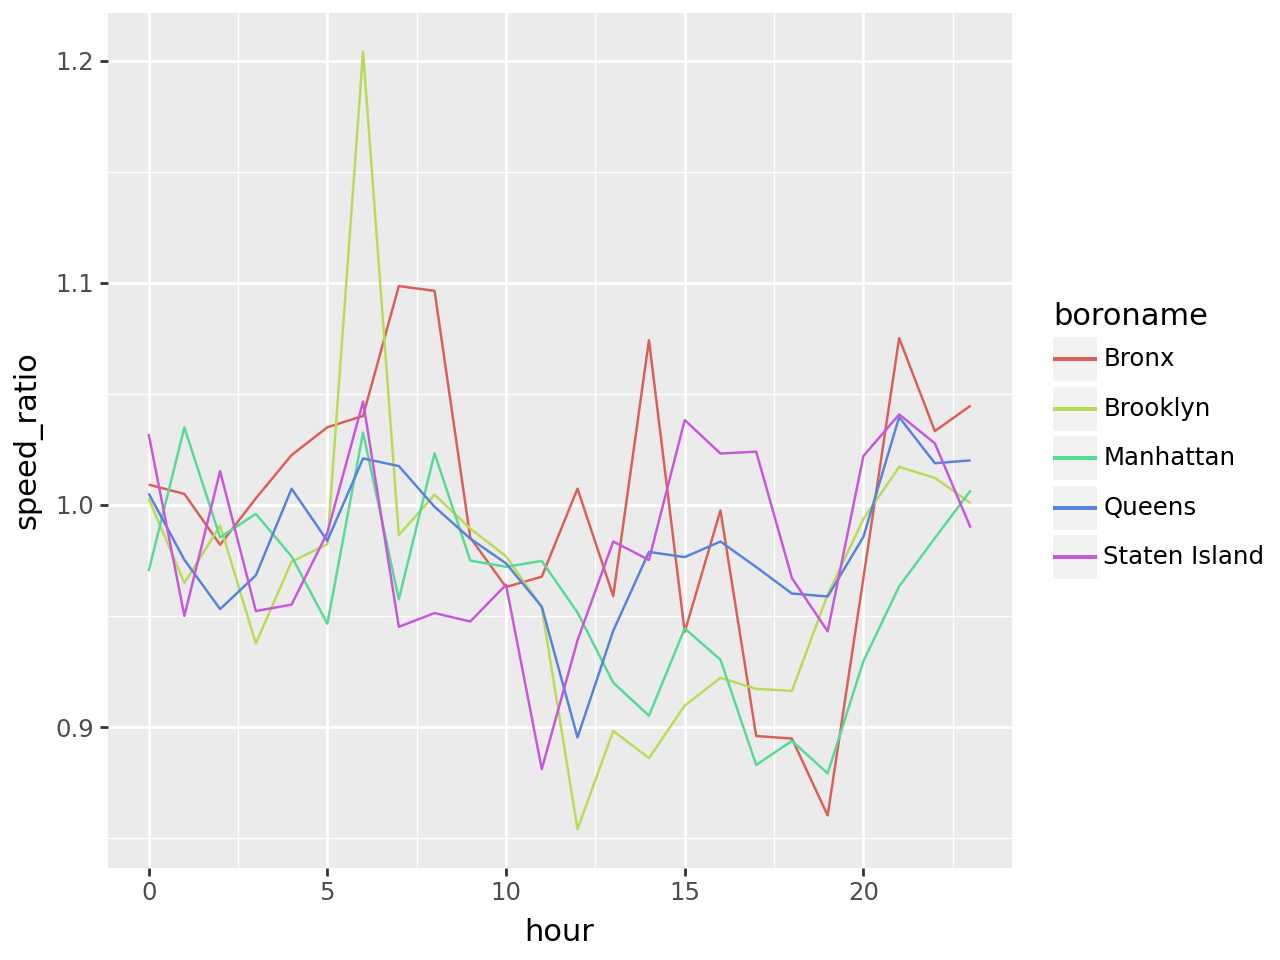

In [10]:
plot_dat = flood_speeds.groupby(["hour", "boroname"])["speed_ratio"].mean().reset_index()
ggplot(plot_dat, aes(x = "hour", y = "speed_ratio", color = "boroname", group = "boroname")) + geom_line()

In [11]:
flood_speeds = gpd.GeoDataFrame(flood_speeds, geometry = flood_speeds["geometry"])

KeyError: 'geometry'

In [ ]:
afternoon = flood_speeds.query("hour.isin([12,13]) & unique_buses_flooding > 10").groupby("ntaname")["speed_ratio"].mean().reset_index()
afternoon = afternoon.merge(ntas)
afternoon_geo = gpd.GeoDataFrame(afternoon, geometry = afternoon["geometry"])

In [ ]:
afternoon_geo

,ntaname,speed_ratio,boroname,geometry
0,Allerton,1.000703,Bronx,"MULTIPOLYGON (((-73.85849 40.87128, -73.85854 ..."
1,Alley Pond Park,1.031243,Queens,"MULTIPOLYGON (((-73.73374 40.74285, -73.73380 ..."
2,Annadale-Huguenot-Prince's Bay-Woodrow,1.007972,Staten Island,"MULTIPOLYGON (((-74.18073 40.54668, -74.18043 ..."
3,Arden Heights-Rossville,0.990594,Staten Island,"MULTIPOLYGON (((-74.17758 40.56376, -74.17659 ..."
4,Astoria (Central),0.820183,Queens,"MULTIPOLYGON (((-73.91194 40.76901, -73.91450 ..."
...,...,...,...,...
234,Windsor Terrace-South Slope,0.632842,Brooklyn,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ..."
235,Woodhaven,0.970510,Queens,"MULTIPOLYGON (((-73.84914 40.69828, -73.84948 ..."
236,Woodlawn Cemetery,0.904122,Bronx,"MULTIPOLYGON (((-73.87407 40.88004, -73.87495 ..."
237,Woodside,0.868693,Queens,"MULTIPOLYGON (((-73.89564 40.74847, -73.89555 ..."


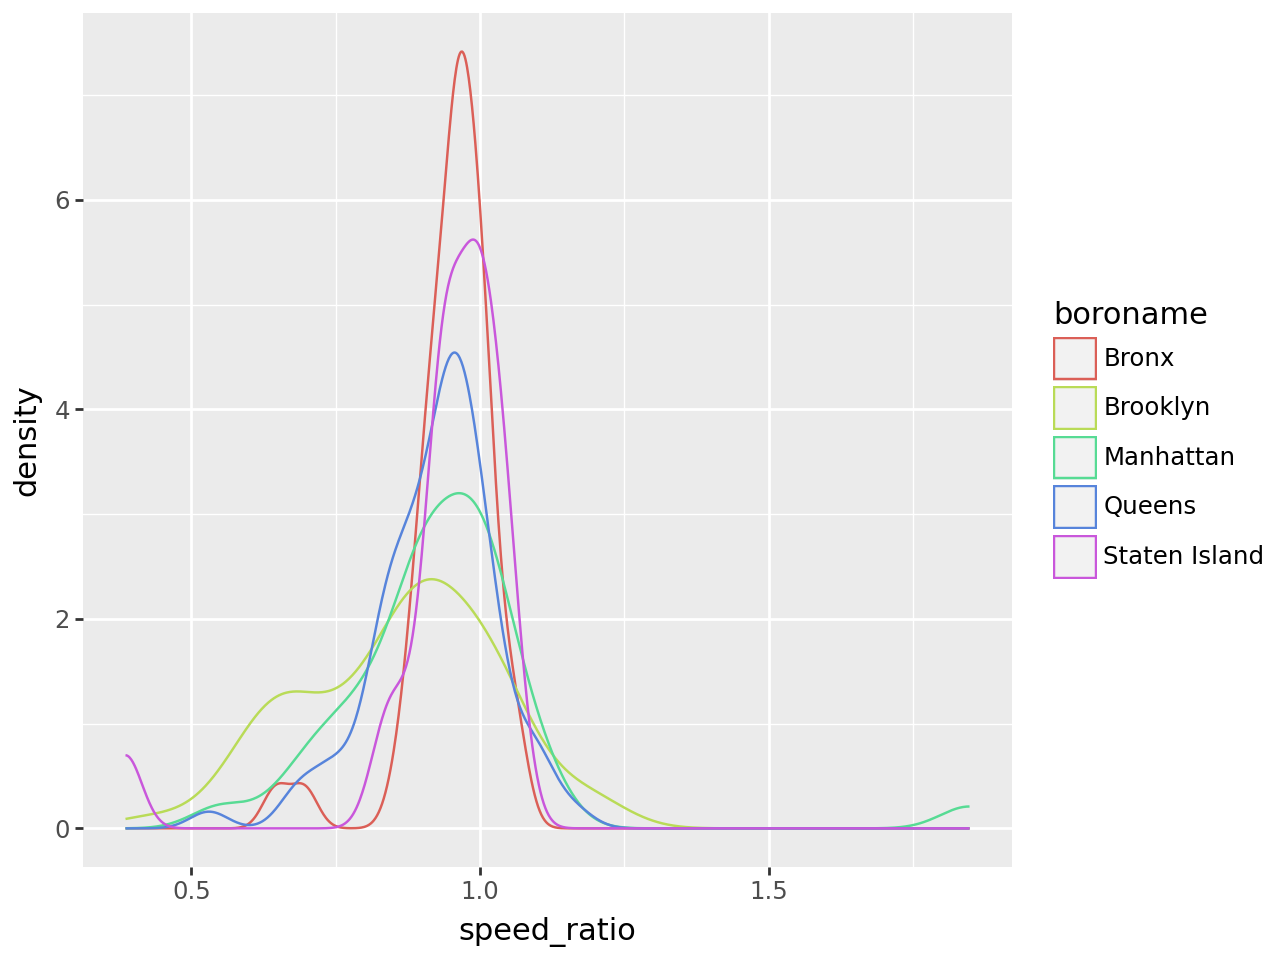

In [ ]:
(ggplot(afternoon_geo, aes(x = "speed_ratio", color = "boroname")) + geom_density())

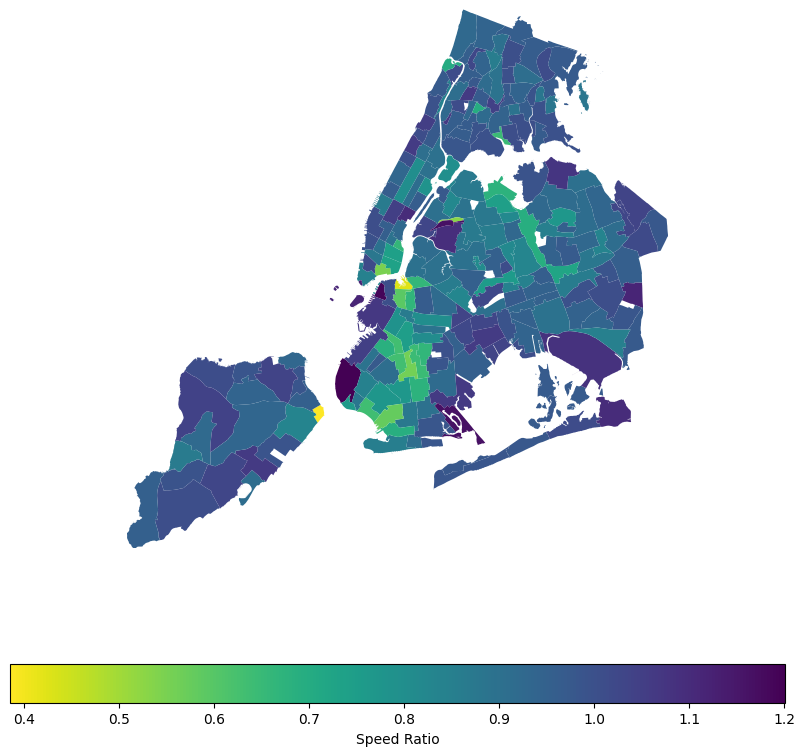

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
afternoon_geo.query("speed_ratio < 1.4").plot(column='speed_ratio', ax=ax, legend=True,
                  legend_kwds={'label': "Speed Ratio", 'orientation': "horizontal"},
                  cmap='viridis_r')  # Reverse Viridis color scale

ax.set_xlim(afternoon_geo.total_bounds[[0, 2]])
ax.set_ylim(afternoon_geo.total_bounds[[1, 3]])

ax.set_axis_off()  # Remove the axes

plt.show()

In [ ]:
afternoon_geo.query("speed_ratio < 1.4").plot(column = "speed_ratio")

<Axes: >